# Model database fetching and inference

## Load model & set up genome

In [1]:
from pathlib import Path
import numpy as np
import keras
import crested

2025-02-04 13:15:56.207636: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 13:15:56.241486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 13:15:58.790778: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model_path, output_names_biccn = crested.get_model("BICCN")
model_biccn = keras.models.load_model(model_path, compile=False)

2025-02-04 13:16:06.799472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78790 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:68:00.0, compute capability: 9.0


In [3]:
# Set the genome
genome_dir = Path("../../../../mouse/biccn/")
genome = crested.Genome(genome_dir / "mm10.fa", genome_dir / "mm10.chrom.sizes")
crested.register_genome(genome)

2025-02-04T13:16:07.490469+0100 INFO Genome mm10 registered.


## Region predictions and contribution scores

In [4]:
chrom = "chr3"
start = 72535878 - 807
end = 72536378 + 807
sequence = genome.fetch(chrom, start, end).upper()

prediction = crested.tl.predict(sequence, model_biccn)

I0000 00:00:1738671367.727769 3255841 service.cc:145] XLA service 0x7f51cc00de10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738671367.727796 3255841 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-02-04 13:16:07.743936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-04 13:16:07.825096: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1738671368.560831 3255841 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


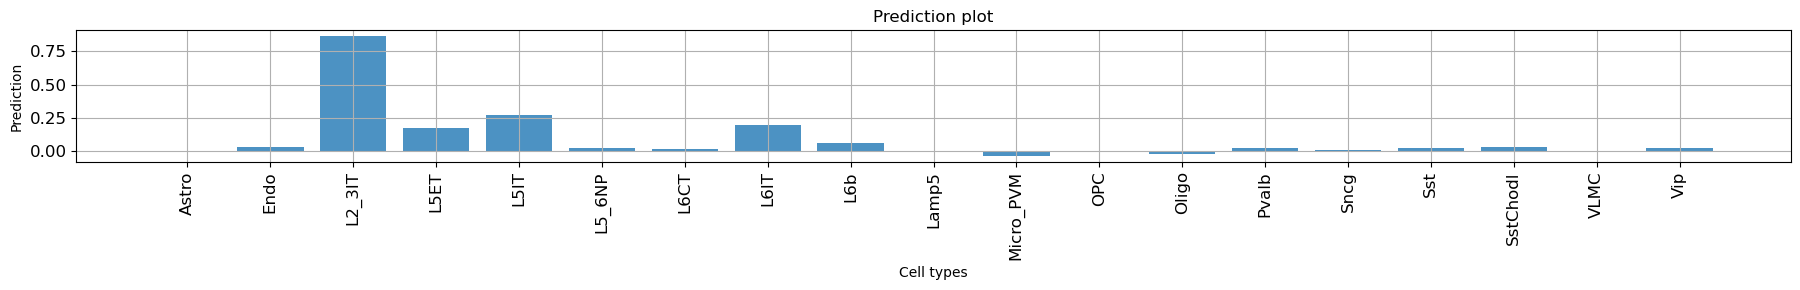

In [5]:
%matplotlib inline
crested.pl.bar.prediction(prediction, classes=output_names_biccn, x_label_rotation=90)

In [6]:
classes_of_interest = [output_names_biccn[np.argmax(prediction)]]
class_idx = [np.argmax(prediction)]

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model_biccn,
)

2025-02-04T13:16:08.698614+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


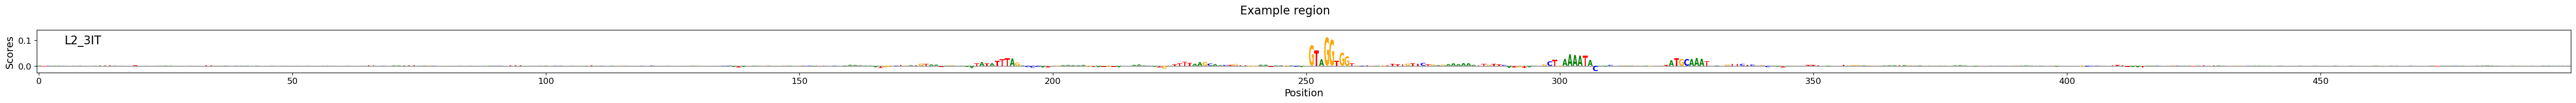

In [7]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[""],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Example region",
)  # zoom in on the center 500bp

### Same region with another model

In [8]:
model_path, output_names_dmb3 = crested.get_model("DeepMouseBrain3")
model_dmb3 = keras.models.load_model(model_path, compile=False)

In [9]:
prediction = crested.tl.predict(sequence, model_dmb3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


/home/VIB.LOCAL/niklas.kempynck/.conda/envs/crested/lib/python3.11/site-packages/crested/pl/_utils.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


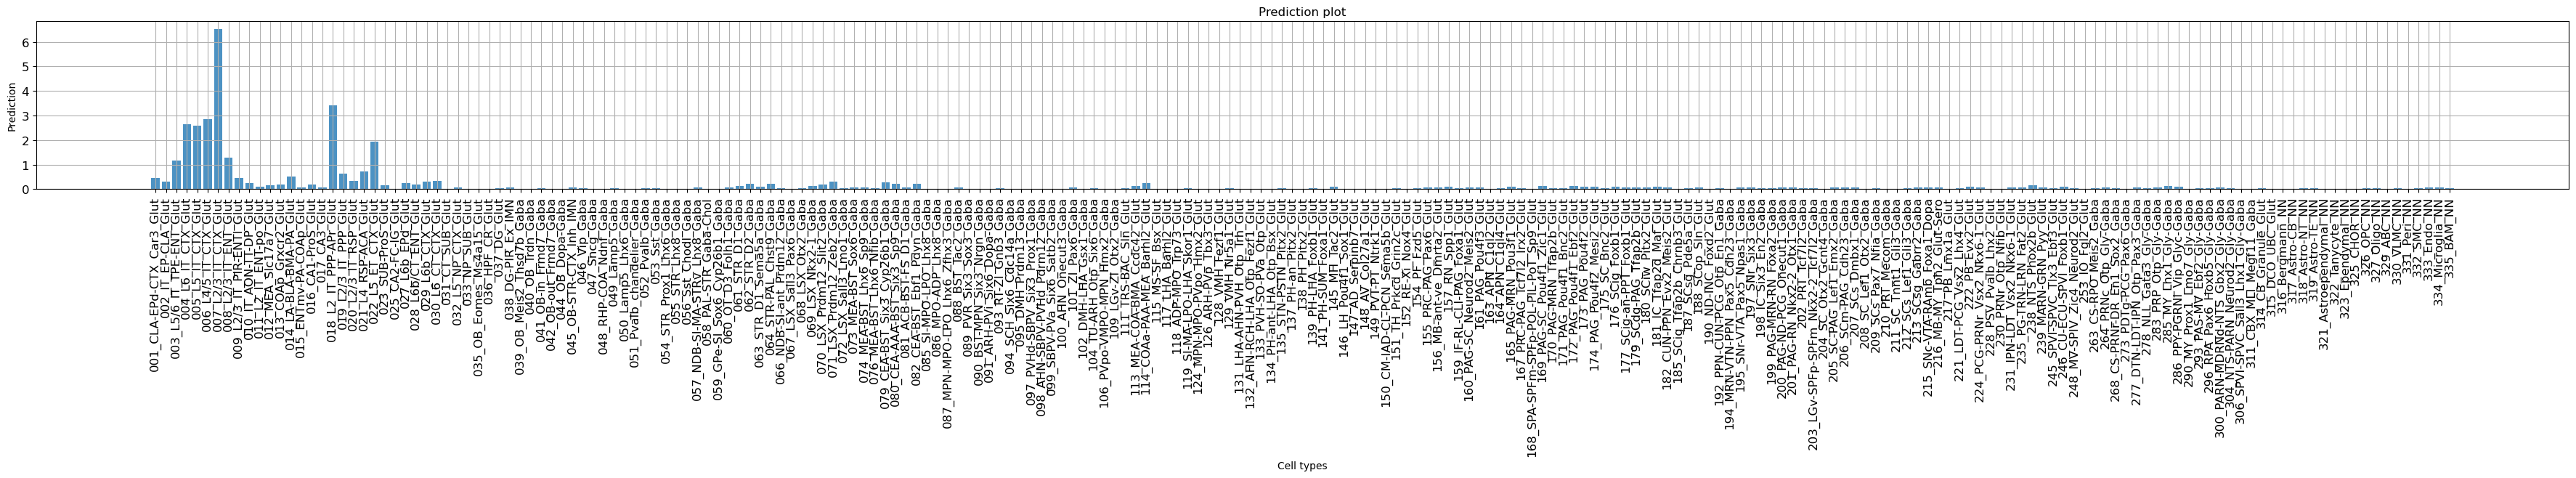

In [10]:
crested.pl.bar.prediction(prediction, classes=output_names_dmb3, x_label_rotation=90, width=45)

In [11]:
classes_of_interest = [output_names_dmb3[np.argmax(prediction)]]
class_idx = [np.argmax(prediction)]

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model_dmb3,
)

2025-02-04T13:16:23.557007+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


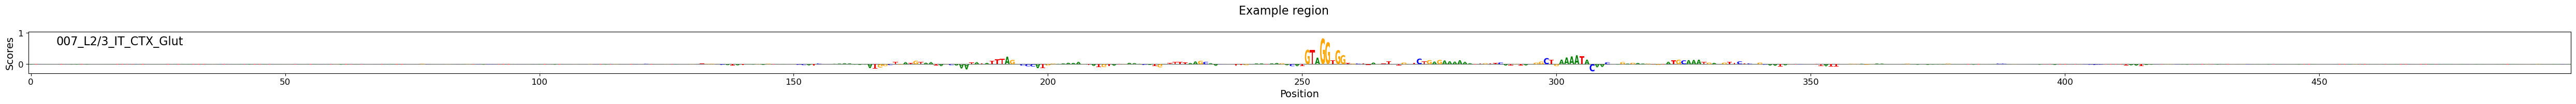

In [12]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[""],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Example region",
)  # zoom in on the center 500bp

## Gene locus predictions

### With BICCN model

In [13]:
chrom = "chr4"
start = 91209533
end = 91374781

cell_type = "Sst"
class_idx = output_names_biccn.index(cell_type)

upstream = 50000
downstream = 25000

strand = "-"

scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    model=model_biccn,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
)

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 2s 687us/step


In [14]:
# Optional
bigwig = "../../../../mouse/biccn/bigwigs/bws/" + cell_type + ".bw"

values = (
    crested.utils.read_bigwig_region(bigwig, (chrom, start - upstream, end + downstream))
    if strand == "+"
    else crested.utils.read_bigwig_region(bigwig, (chrom, start - downstream, end + upstream))
)
bw_values = values[0]
midpoints = values[1]

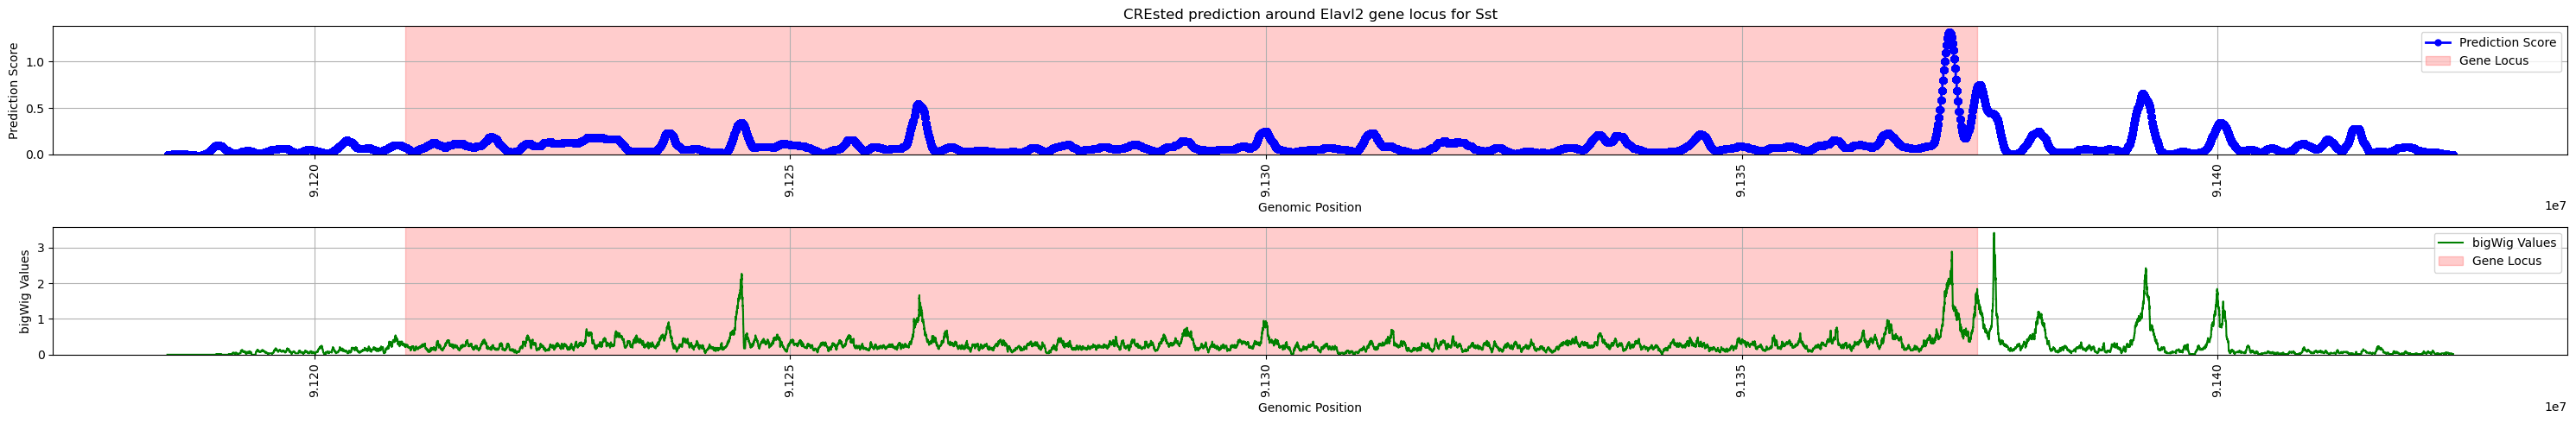

In [15]:
%matplotlib inline
crested.pl.hist.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around Elavl2 gene locus for Sst",
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
)

### With DeepMouseBrain3

In [16]:
scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    model=model_dmb3,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
)

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


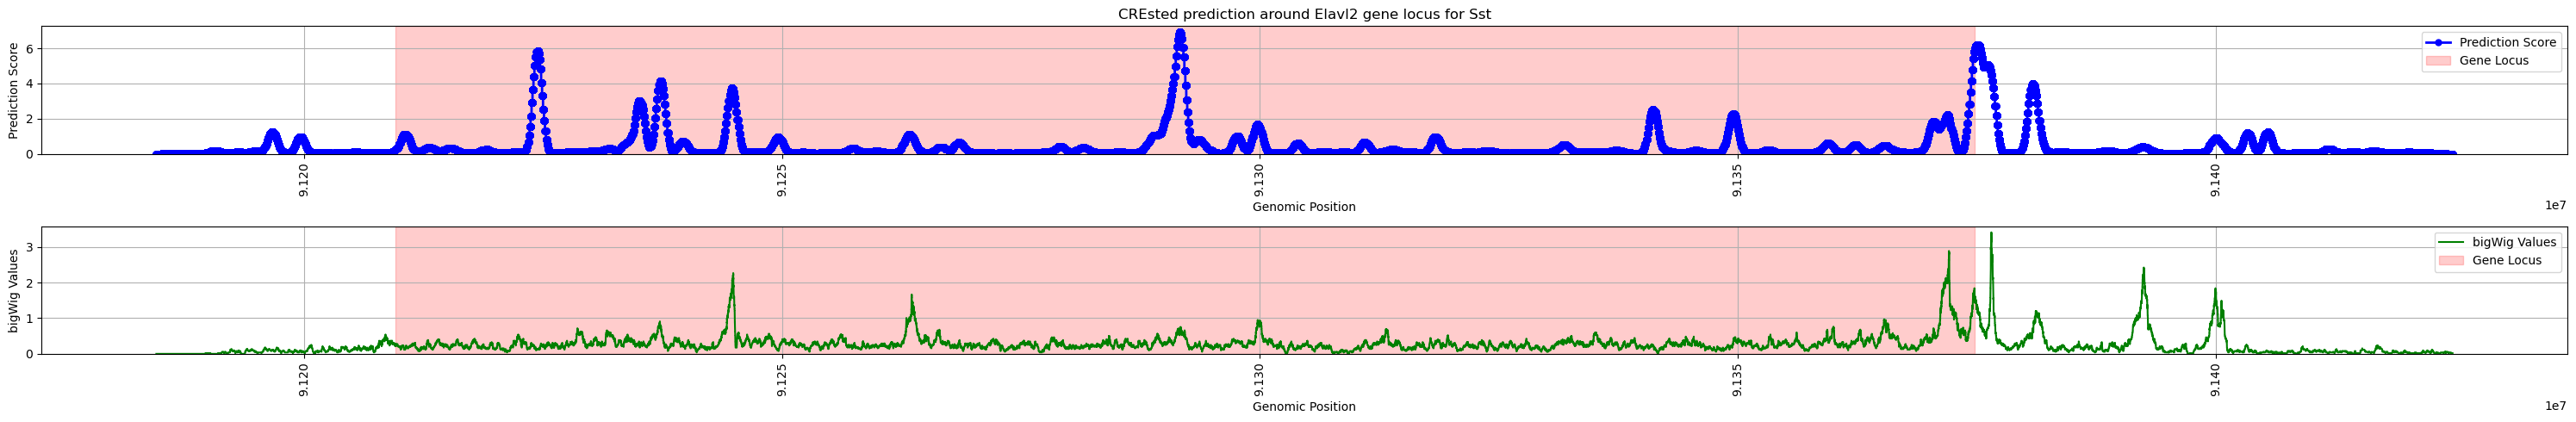

In [17]:
%matplotlib inline
crested.pl.hist.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around Elavl2 gene locus for Sst",
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
)